1. Read all the TSV files into an array, write a function to extract the title and authors data
2. Go through each TSV and use title and authors to search the OCLC for OWI number
3. Go through each OWI and get:
    3.1 Earliest year published
    3.2 Holdings
    3.3 For OWI with the most holdings: VIAF -> Genders
    3.5 For each OWI where "book" in .get("format")
    Make Genders -> DDC dict, add to it manually
4. Make a dict of TITLE/AUTHOR STRING -> OWI, YEAR_PUBLISHED, GENDER(S), TOP_DDC, FAST_LIST?

In [1]:
import csv, os
from datetime import datetime
#import datetime
f_filen = "tabula-1963-03-17.tsv"
nf_filen = "tabula-1963-03-17-nf.tsv"
data_i = 2 #How far into the tsv file the data shows up...
fields = ['rank','title+author','rank_last_week','weeks_on_list']
stop_words_authors = ["Others"]

# Read the Data In

In [2]:
def empty(row):
    if row[0]=="":
        return True
    return False 

def extract_date(datestr):
    try:
        date = datetime.strptime(datestr[0],'%B %d, %Y')
    except ValueError:
        date = datetime.strptime(datestr[0],'%B %d,%Y')
    return date

def extract_date_filen(datestr):
    f_from_path = datestr.split("/")[2]
    wo_extension = f_from_path.split(".")[0]
    date = datetime.strptime(wo_extension,'%Y-%m-%d')
    return date

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def header(row):
    if is_number(row[0]):
        return False
    else:
        return True
    
def read_tsv(name):
    i = 0
    arr = []
    date = ""
    with open(name) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        previous_previous_row = ""
        previous_row = ""
        for row in reader:
            if (not empty(row)):
                if (header(row)) & (i>data_i):
                    return arr
                if i==0:
                    date_field = [row[1]]
                    if row[1] == "":
                        date_field = [row[2]]
                    try:
                        date = extract_date(date_field)
                    except:
                        date = extract_date_filen(name)
                if (i >= data_i):
                    if row[1] == "":
                        row[1] = previous_row[1]
                    arr.append([date]+row)
                i = i+1
            previous_row = row
        return arr
    
def read_folder(folderpath):
    arr = []
    for f in os.listdir(folderpath):
        commasv = read_tsv(folderpath+f)
        arr = arr+commasv
    return arr

eighty_path = "tsvs/1980s/"
eighties = read_folder(eighty_path)
seventies_path = "tsvs/1970s/"
seventies = read_folder(seventies_path)
sixties_path = "tsvs/1960s/"
sixties = read_folder(sixties_path)
fifties_path = "tsvs/1950s/"
fifties = read_folder(fifties_path)

nineties = read_folder("tsvs/1990s/")
thousands = read_folder("tsvs/2000s/")

for x in nineties[0:10]:
    print x
    
    
to_process = fifties + sixties + seventies + eighties + nineties + thousands
print len(to_process)

[datetime.datetime(1990, 1, 7, 0, 0), '1', 'THE DARK HALF, by Stephen King. (Viking, $21.95.) After a writer of horror tales', '2', '10']
[datetime.datetime(1990, 1, 7, 0, 0), '2', 'DADDY, by Danielle Steel. (Delacorte, $19.95.) Unexpected crises wreck the safe,', '1', '8']
[datetime.datetime(1990, 1, 7, 0, 0), '3', "CLEAR AND PRESENT DANGER, by Tom Clancy. (Putnam, $21.95.) The C.I.A.'s", '3', '19']
[datetime.datetime(1990, 1, 7, 0, 0), '4', 'CARIBBEAN, by James A. Michener. (Random House, $22.95.) The history of the', '4', '8']
[datetime.datetime(1990, 1, 7, 0, 0), '5', "FOUCAULT'S PENDULUM, by Umberto Eco. (Wolff/Harcourt Brace Jovanovich,", '6', '12']
[datetime.datetime(1990, 1, 7, 0, 0), '6', 'TALES FROM MARGARITAVILLE, by Jimmy Buffett. (Harcourt Brace Jovanovich,', '10', '12']
[datetime.datetime(1990, 1, 7, 0, 0), '7', 'THE POLAR EXPRESS, written and illustrated by Chris Van Allsburg. (Houghton', '5', '24']
[datetime.datetime(1990, 1, 7, 0, 0), '8', 'JIMMY STEWART AND HIS POEMS,

# Get Title and Author

In [3]:
import pickle

def write_obj(obj,filename):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
        return b

from_pdf_dict = load_obj("from_pdf_manual2.pickle")

In [4]:
skip_these = set()

In [6]:
auth_i = 4

# strip trailing char if '.' or ' '
def strip_trailing_punct(a):
    last_char = a[len(a)-1]
    if (last_char != '.') & (last_char != ' '):
        return a
    b = a[:len(a)-1] 
    return strip_trailing_punct(b)


def parse_author_phrase(a_ph):
    authors = []
    end = len(a_ph)
    parens = a_ph.find("(")
    if parens != -1:
        end = parens-1
    auth_ph = a_ph[auth_i:end]
    if " and " in auth_ph.lower():
        author_arr = auth_ph.lower().split(" and ")
        for author in author_arr:
            author = strip_trailing_punct(author)
            if author not in stop_words_authors:
                authors.append(author)
    else:
        author = auth_ph
        author = strip_trailing_punct(author)
        authors.append(author)
    return authors

def title_author_pair(data_str):
    if data_str in from_pdf_dict:
        return from_pdf_dict[data_str]
    split_str = data_str.split(',')
    title = ""
    auth_ph = ""
    i=0
    t=True
    for phrase in split_str:    
        if i == 0:
            title = phrase
        else:
            if phrase.isupper() & t:
                title = title + ", "+phrase
            else:
                t = False
                auth_ph = auth_ph+phrase
        i = i+1
    try:
        authors = parse_author_phrase(auth_ph)
        if authors == []:
            authors = [data_str]
    except:
        skip_these.add(data_str)
        authors = [data_str]
    return (title,authors)

ta = []
i = 0
for x in to_process:
    title_author = title_author_pair(x[2])
#    if title_author in skipped_ta:
#        if [x[2],title_author] not in ta:
#            i = i+1
#            #print sta
#            ta.append([x[2],title_author])
print "len ta = "+str(len(ta))



i =0 
for x in ta:
    print x
    i = i+1
    if i>10:
        break


len ta = 0


In [40]:
#new_from_pdf_dict = {}

test_set = ("MIRAGE, by Clive Cussler with Jack Du Brul. (Putnam.) Juan Cabrillo and the crew",
            "DEAD OR ALIVE, by Tom Clancy with Grant Blackwood. (Putnam, $28.95.) Familiar", 
            "THE FALL OF ARTHUR, by J. R. R. Tolkien. Edited by Christopher Tolkien.",
            "ROGUES, edited by George R. R. Martin and Gardner Dozois. (Bantam.) Twenty-one")

for x in ta:
    if x[0] not in new_from_pdf_dict:
        for y in x:
            print y
        title = raw_input("title :")
        if title != "":
            authors = []
            while True:
                a = raw_input("author :")
                if a == "":
                    break
                authors.append(a)
            new_from_pdf_dict[x[0]] = (title,authors)

BARABBAS, by Par Lagerkvist.
('BARABBAS', ['Par Lagerkvist'])
title :
YOU SHALL KNOW THEM, by Rita Vercors.
('YOU SHALL KNOW THEM', ['Rita Vercors'])
title :
STICKS & SCONES, by Diane Mott Davidson. (Bantam, $23.95.) The professional
('STICKS & SCONES', ['Diane Mott Davidson'])
title :
THE DIARY OF ELLEN RIMBAUER, edited by Joyce Reardon. (Hyperion,
('THE DIARY OF ELLEN RIMBAUER', ['ted by Joyce Reardon'])
title :THE DIARY OF ELLEN RIMBAUER
author :Ellen Rimbauer
author :Joyce Reardon
author :
THE NEW JEDI ORDER: DESTINY'S WAY, by Walter Jon Williams. (Lucas/Del
("THE NEW JEDI ORDER: DESTINY'S WAY", ['Walter Jon Williams'])
title :
LAWRENCE SANDERS: McNALLY'S DARE, by Vincent Lardo. (Putnam, $24.95.)
("LAWRENCE SANDERS: McNALLY'S DARE", ['Vincent Lardo'])
title :
THE DARK TOWER: Volumes 1-5, by Stephen King. (Viking and Donald M.
('THE DARK TOWER: Volumes 1-5', ['Stephen King'])
title :THE DARK TOWER
author :Stephen King
author :
THE NEW JEDI ORDER: THE UNIFYING FORCE, by James Luceno.

In [41]:
from_pdf_dict.update(new_from_pdf_dict)
write_obj(from_pdf_dict,"from_pdf_manual2.pickle")

# To OCLC


In [7]:
import xml.etree.ElementTree
import json
import urllib2
import re

ta_to_data_dict = load_obj("the_final.pickle") 
oclc_base = "http://classify.oclc.org/classify2/Classify?"
alph = re.compile('[^a-zA-Z]')
suffixes = ['CPA', 'CSC', 'CSJ', 'DC', 'DD', 'DDS', 'DMD', 'DO', 'DVM', 'EDD', 'ESQ', 'II', 'III', 
            'IV', 'INC', 'JD', 'JR', 'LLD', 'LTD', 'MD', 'OD', 'OSB', 'PC', 'PE', 'PHD', 'RET', 
            'RGS', 'RN', 'RNC', 'SHCJ', 'SJ', 'SNJM', 'SR', 'SSMO', 'USA', 'USAF', 'USAFR', 'USAR', 
            'USCG', 'USMC', 'USMCR', 'USN', 'USNR']

In [8]:
def suffix(phrase):
    norm_phrase = phrase.replace(',',"").upper()
    if norm_phrase in suffixes:
        return True
    else:
        return False
    
def strip_punct(text):
    return alph.sub('', text)

def norm_text(text):
    return strip_punct(text).lower()

def url_to_data(url,f):
    req = urllib2.Request(url)
    req.add_header('User-agent', 'Mozilla 5.10')
    res = urllib2.urlopen(req)
    if(f=="xml"):
        data = xml.etree.ElementTree.parse(res).getroot()
    if(f=="json"):
        data = json.load(res)
    return data

def convert_to_search(name):
    return_string = ""
    last_ch = " "
    for ch in name:
        if (ch == " "):
            if (last_ch != "."):
                return_string = return_string + "+"
        else:
            if ch == ".":
                return_string = return_string +".+"
            else:
                if ch == "'":
#                    print "adding char encoding"
                    return_string = return_string+"%27"
                else:
                    return_string = return_string+ch
        last_ch = ch
    return return_string

def last_name_recursive(name,last_index):
    if last_index == 0:
        return ""
    last_phrase = name[last_index]
    if not suffix(last_phrase):
        return last_phrase
    else:
        return last_name_recursive(name, last_index-1)

def last_name(name):
    names = name.split(" ")
    last_index = len(names)-1
    last = last_name_recursive(names,last_index)
    return last

def first_name(name):
    names = name.split(" ")
    return names[0]

In [9]:
from lxml import html
from bs4 import BeautifulSoup
import requests

viaf_base = "http://www.viaf.org/viaf/"
    
def get_gender_scrape(i):
    url = viaf_base+str(i)+"/"
    data = requests.get(url).text
    soup = BeautifulSoup(data,"lxml")
    personal = soup.find('div',{'id':'personalinfo'})
    if personal is None:
        return ""
    h4s = personal.find('h4')
    if (h4s is None) or (len(h4s)<5):
        return ""
    mt = []
    i=0
    for h in h4s:
        mt.append(h)
        i = i+1
    return str(mt[4])

In [10]:
import fuzzywuzzy
from fuzzywuzzy import fuzz
fuzz_thresh = 80

def fuzzy_substr(s1,s2):
    teststr = norm_text(s1)
    checkstr = norm_text(s2)
    ratio = fuzz.partial_ratio(teststr,checkstr)
#    print teststr
#    print checkstr
#    print ratio
    if ratio >= fuzz_thresh:
        return True
    else:
        return False
    
    
def alt_is_book(w,t,a):
    if "book" in norm_text(w.get("format")):
        check_title = w.get("title")
        if (check_title is not None) and (fuzzy_substr(t,check_title)):
            for auth in a:
                check_author = w.get("author")
                if (check_author is not None) and (fuzzy_substr(last_name(auth),check_author)):
                    if fuzzy_substr(first_name(auth),check_author):
                        return True
    return False

def alt_get_viaf(author, viaf_dict_arr):
    l = last_name(author)
    f = first_name(author)
    target = ""
    for v in viaf_dict_arr:
        if fuzzy_substr(l,v['name']):
            target = v['viaf']
            if fuzzy_substr(f,v['name']):
                return v['viaf']
    return target


def is_book(w,t,a):
#    print w
#    print t
#    print a
    if "book" in norm_text(w.get("format")):
#        print norm_text(t)
#        print norm_text(w.get("title"))
        if norm_text(t) in norm_text(w.get("title")):
#            print "inside if"
            for auth in a:
#                print last_name(auth)
#                print first_name(auth)
                if norm_text(last_name(auth)) in norm_text(w.get("author")):
                    if norm_text(first_name(auth))in norm_text(w.get("author")):
                        return True
    return False

def find_all_works(xml,title,authors):
    works = xml.find('{http://classify.oclc.org}works')
    if works is None:
        works = []
        works.append(xml.find('{http://classify.oclc.org}work'))
#        print works
        if (works is None) or (works == []) or (works[0] is None):
            return []
    books = []
    for w in works:
        holdings = w.get("holdings")
        if (int(holdings) > 10) & (alt_is_book(w,title,authors)):
            owi = w.get("owi")
            try:
                lyr = w.get("lyr")
            except:
                lyr = ""
            books.append({"owi":owi,"holdings":holdings,"lyr":lyr})
    #print "NUM BOOKS: "+str(len(books))
    return books

def new_work(w, entries):
    if int(w['holdings']) < 50:
        return False
    for e in entries:
        if w['owi'] == e["owi"]:
             return False
    return True

def get_oclc_entries(title,authors):
    url = oclc_base +"title="+convert_to_search(title)
    #i = 0
    entries = []
    for a in authors:
        auth_url = url +"&author=" + last_name(a)
#        print auth_url
        xml = url_to_data(auth_url,"xml")
#        print xml
#        try:
        works = find_all_works(xml,title,authors)
#        except:
#            return []
        if works is None:
            return []
        if entries == []:
            entries = works
        else:
            for w in works:
                if new_work(w,entries):
                    entries.append(w)
        #i = i+1
    return entries

def max_holding(oarr):
    target = oarr[0]
    for o in oarr[1:]:
        if int(o['holdings'])>int(target['holdings']):
            target = o
    return target

def get_authors(xml):
    authors = xml.find('{http://classify.oclc.org}authors')
    target = []
    for a in authors:
        text = a.text
        v = a.get('viaf')
        target.append({'name':text, 'viaf':v})
    return target

def get_fast(xml):
    recs = xml.find('{http://classify.oclc.org}recommendations')
    target = []
    if recs is not None:
        fast = recs.find('{http://classify.oclc.org}fast')
        if fast is not None:
            headings = fast.find('{http://classify.oclc.org}headings')
            for h in headings:
                holdings = h.get('heldby')
                subject = h.text
                if int(h.get('heldby'))>10:
                    target.append({'subject':subject,'holdings':holdings})
    return target

def lookup_oclc(owi):
    url = oclc_base+"owi="+owi
    xml = url_to_data(url,"xml")
    try:
        v = get_authors(xml)
    except:
        print url
        print xml
        response_code = xml.find('{http://classify.oclc.org}response').get("code")
        if response_code == '102':
            print '102!'
        v = [{'name':'','viaf':''}]
    fast = get_fast(xml)
    target = {'authors':v,'fast':fast}
    return target

test_author_dict = [{'viaf': '22619695', 'name': 'Bailey, Charles Waldo, 1929-2012 [Author]'}, {'viaf': '19720195', 'name': 'Knebel, Fletcher'}]

def get_genders(authors, viaf_dict):
    target = []
    for a in authors:
        v = alt_get_viaf(a,viaf_dict)
        gender = get_gender_scrape(v)
        target.append({"name":a,"viaf":v,"gender":gender})
    return target
    
def get_viaf(author, viaf_dict_arr):
    l = norm_text(last_name(author))
    f = norm_text(first_name(author))
    target = ""
    for v in viaf_dict_arr:
        if l in norm_text(v['name']):
            target = v['viaf']
            if f in norm_text(v['name']):
                return v['viaf']
    return target

print(get_genders(["Fletcher Knebel","Charles W. Bailey II"],test_author_dict))

[{'gender': 'Male', 'viaf': '19720195', 'name': 'Fletcher Knebel'}, {'gender': 'Male', 'viaf': '22619695', 'name': 'Charles W. Bailey II'}]


In [11]:
import random
def ta_str_to_pair(ta_str):
    junk_ls = ta_str.split(',')
    title = ''
    j = 0
    for x in junk_ls:
        j = j+1
        t = re.sub("[('\[\]\)\"]", '', x)
        if t.isupper():
            if j != 1:
                t = ','+t
            title = title + t
        else:
            break
    authors = []
    for x in junk_ls[j-1:]:
        a = re.sub("[('\[\]\)\"]", '', x)
        if a[0]==' ':
            a = a[1:]
        authors.append(a)
    return (title,authors)

def compare_oclcs(a,b,c):
    if len(a) == len(b):
        if len(b) == len(c):
            return True
        else:
            print "90 picked up more than 100!"
            for x in b:
                if x not in c:
                    print x
            return False
    else:
        print "80 picked up more than 90!"
        for x in a:
            if x not in b:
                print x
        print "80 also picked up more than 100!"
        for x in a:
            if x not in c:
                print x
        return False


i=0
while i<40:
    randtastr= random.choice(ta_to_data_dict.keys())
    ta = ta_str_to_pair(randtastr)
    fuzz_thresh = 75
    oclc_80 = get_oclc_entries(ta[0],ta[1])
    fuzz_thresh = 80
    oclc_90 = get_oclc_entries(ta[0],ta[1])
    fuzz_thresh = 90
    oclc_100 = get_oclc_entries(ta[0],ta[1])
    if not compare_oclcs(oclc_80,oclc_90,oclc_100):
        print ta
    i = i+1


90 picked up more than 100!
{'holdings': '4319', 'owi': '4945815', 'lyr': '1986'}
{'holdings': '349', 'owi': '3943369156', 'lyr': '1986'}
('GUMP & CO.', ['Winston Groom'])


In [19]:
fuzz_thresh = 80

test_tas = [("LADY CHATTERLY'S LOVER",["D.H. Lawrence"]),
            ("THE PLYMOUTH ADVENTURE",["Ernest Gebler"]),
            ("SLEEP TILL NOON",["Max Shulman"]),
            ('THE SHELTERS OF STONE', ['Jean M.Auel']),
            ("BARABBAS",["Par Lagerkvist"]),
            ("YOU SHALL KNOW THEM",["Rita Vercors"])]

for x in test_tas:
    print new_process_input_data(x)

{'genders': [{'gender': 'Male', 'viaf': '95150359', 'name': 'D.H. Lawrence'}], 'year_pub': '1928', 'owi': '473258347', 'fast_subjects': {'Married women': 1481, 'Gamekeepers': 1485, 'Aristocracy (Social class)': 559, 'Great Britain': 215, 'Adultery': 1716, 'English fiction': 75, 'England': 1552, 'Runaway wives': 559}}
{'genders': [{'gender': 'Male', 'viaf': '79470343', 'name': 'Ernest Gebler'}], 'year_pub': '1940', 'owi': '1472514', 'fast_subjects': {'Mayflower (Ship)': 839, 'Massachusetts': 894}}
{'genders': [{'gender': 'Male', 'viaf': '67949831', 'name': 'Max Shulman'}], 'year_pub': None, 'owi': '148176688', 'fast_subjects': {'Marriage': 41}}
{'genders': [{'gender': 'Female', 'viaf': '79487364', 'name': 'Jean M.Auel'}], 'year_pub': '1985', 'owi': '530222', 'fast_subjects': {'Europe': 6229, 'Ayla (Fictitious character)': 6716, 'Neanderthals': 15, 'Prehistoric peoples': 6782, 'Cro-Magnons': 15, 'Parents-in-law': 15, 'Glacial epoch': 6648, 'Women': 30}}
{'genders': [], 'year_pub': [], 'o

In [18]:
skipped_ta = []
print len(ta_to_data_dict)

5500


In [16]:
def process_input_data(ta):       
    # if str(ta) not in ta_to_oclc_dict: CHECK FOR THIS OUTSIDE THE FN
    title = ta[0]
    author = ta[1]

    oclc = get_oclc_entries(title,author)
#    print oclc is None
#    print len(oclc)<1
    if (oclc is None) or (len(oclc)<1):
        skipped_ta.append(ta)
        owi = ""
        holdings = []
        year_pub = []
        fast_subjects = set()
        genders = []
    else:
        if len(oclc) == 1:
            primary = oclc[0]
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = set(primary_data['fast'])
        else:
            primary = max_holding(oclc)
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = set(primary_data['fast'])
            for o in oclc:
                if o['owi'] != primary['owi']:
                    other_data = lookup_oclc(o['owi'])
                    fast_subjects.update(other_data['fast'])
        owi = primary["owi"]
        year_pub = primary["lyr"]
        genders = get_genders(author, primary_data['authors'])
    return {"owi": owi, "year_pub": year_pub, "fast_subjects":fast_subjects, "genders":genders}

## need to add the original data (date, year, rankings) if this is the ultimate output
def process_raw_list(input_ls):
    #print "INPUT! "+ str(input_ls)
    target = []
    i = 0
    for row in input_ls:
        if row[2] != "UNKNOWN":
            date = row[0]
            year = date.year
            streak = row[4]
            rank = row[1]
            ta = title_author_pair(row[2])
            target_row = {"date":date,"title":ta[0],"authors":ta[1],"year":year,"rank":rank,"streak":streak}
            string_ta = str(ta)
            if string_ta in ta_to_data_dict:
                target_row.update(ta_to_data_dict[string_ta])
            else:
                try:
                    ## FOR THE NEW STUFF! THE LAST TIME I'M PULLING IT I SWEAR
                    p = process_input_data(ta)
                    target_row.update(p)
                    if ((p["owi"] != "") & (len(p['genders'])>0) & (len(p['fast_subjects'])>0)):
                        ta_to_data_dict[string_ta] = p
                        j = len(ta_to_data_dict)
                        if ((j%25 == 0) or (i == (len(input_ls)-1))):
                            print j
                            write_obj(ta_to_data_dict,"free_range.pickle")
                except:
                    print "Unexpected error:", sys.exc_info()[0]
                    return target
        target.append(target_row)
        i = i+1
    return target



In [51]:
alternative_gender = load_obj("adult_alternative.pickle")
new_skipped_ta = []

In [68]:
def new_get_genders(owi):
    target = []
    data = lookup_oclc(owi)
#    print data
    authors = data["authors"]
    for author in authors:
        n = author["name"]
        v = author["viaf"]
        g = get_gender_scrape(v)
        target.append({'name':n,'viaf':v,'gender':g})
    return target    

def clean_ta_dict(ta_dict,container):
    copy = dict(ta_dict)
    target = {}
    for ta in copy:
        if ta not in container:
            data = copy[ta]
            owi = data["owi"]
            try:
                genders = new_get_genders(owi)
                if len(genders) != 0:
                    data["genders"] = genders
                    target[ta] = data  
                    if len(target)%100:
                        alternative_gender=target
                    else:
                        new_skipped_ta.append(ta)
            except KeyboardInterrupt:
                return target
            except:
                new_skipped_ta.append(ta)
    return target

alternative_gender.update(clean_ta_dict(sample,alternative_gender))
write_obj(alternative_gender,"adult_alternative.pickle")

In [69]:
print len(alternative_gender)
print len(new_skipped_ta)

5500
63


In [77]:
#print alt_update

#alternative_gender.update(alt_update)
#print len(alternative_gender)

{"('THE INCIDENT', ['Marc Rivette'])": {'genders': [], 'year_pub': None, 'owi': '32112269', 'fast_subjects': {'Shipwrecks': 75}}, "('ANGELIQUE', ['Sergeanne Golon'])": {'genders': [], 'year_pub': '1967', 'owi': '4095522365', 'fast_subjects': {'Canada': 83, 'Louis XIV, King of France, 1638-1715': 154, 'France': 287}}, "('SECRET HONOR', ['W. E. B. Griffin'])": {'genders': [], 'year_pub': '1999', 'owi': '19833876', 'fast_subjects': {'United States': 311, 'Hitler, Adolf, 1889-1945': 311, 'Secret service': 3679, 'World War (1939-1945)': 3679, 'Attempted assassination': 311}}, "('OAKDALE CONFIDENTIAL', ['Anonymous'])": {'genders': [], 'year_pub': '', 'owi': '1083363448', 'fast_subjects': {'Murder': 1144}}, "('COME WITH ME TO MACEDONIA', ['Leonard Drohan'])": {'genders': [], 'year_pub': None, 'owi': '1832693', 'fast_subjects': {'United States': 166, 'Politics and government': 166}}, "('KG 200', ['j.d. gilman', 'john clive'])": {'genders': [], 'year_pub': '1977', 'owi': '3768493290', 'fast_sub

In [38]:
random.seed = 0
i = 0
while i<10:
    ta = random.choice(alternative_gender.keys())
    gen = alternative_gender[ta]["genders"]
    if len(gen)>1:
        print ta
        print gen
        i=i+1

('DANCE OF DEATH', ['douglas preston', 'lincoln child'])
[{'gender': 'Male', 'viaf': '57543887', 'name': 'douglas preston'}, {'gender': '', 'viaf': '', 'name': 'lincoln child'}]
('EXTREMELY LOUD AND INCREDIBLY CLOSE', ['Jonathan Safran Foer'])
[{'gender': 'Male', 'viaf': '66691825', 'name': 'Ahrens, Henning [Translator; Creator]'}, {'gender': 'Male', 'viaf': '85500702', 'name': 'Foer, Jonathan Safran, 1977-'}]
("THE TRAVELER'S GIFT", ['Andy Andrews'])
[{'gender': 'Male', 'viaf': '107581069', 'name': 'Andrews, Andy, 1959-'}, {'gender': 'Female', 'viaf': '36312984', 'name': 'Parker, Amy, 1976-'}, {'gender': 'Male', 'viaf': '21013258', 'name': u'D\xedaz de Arce, Omar'}]
('DESECRATION', ['tim lahaye', 'jerry b. jenkins'])
[{'gender': 'Male', 'viaf': '44301126', 'name': 'tim lahaye'}, {'gender': 'Male', 'viaf': '61669297', 'name': 'jerry b. jenkins'}]
('LOCKED ON', ['Tom Clancy', 'Mark Greaney'])
[{'gender': 'Male', 'viaf': '108842694', 'name': 'Tom Clancy'}, {'gender': 'Male', 'viaf': '101

In [85]:
import sys

## STORES FAST SUBJECTS AS A SINGLE DICT, 
## SUBJECTS ARE KEYS HOLDINGS ARE VALUES

ta_to_owi_dict = load_obj("ta_to_owi.pickle")

def update_fast(orig_fast,new_fast):
    for item in new_fast:
        subject = item["subject"]
        holdings = int(item["holdings"])
        if subject in orig_fast:
            orig_fast[subject] = orig_fast[subject] + holdings
        else:
            orig_fast[subject] = holdings        
    return orig_fast

def convert_to_oclc_dict(owi_ls):
    target = []
    max_hold = len(owi_ls)*10
    i=0
    for x in owi_ls:
        new_row = {}
        new_row["owi"] = x
        new_row["holdings"] = max_hold*10-i
        new_row["lyr"] = ""
        target.append(new_row)
        i = i+1
    return target

def new_process_input_data(ta):       
    title = ta[0]
    author = ta[1]
    if str(ta) in ta_to_owi_dict:
        owi_ls = ta_to_owi_dict[str(ta)]
        oclc = convert_to_oclc_dict(owi_ls)
    else:
        oclc = get_oclc_entries(title,author)
    if (oclc is None) or (len(oclc)<1):
        skipped_ta.append(ta)
        owi = ""
        holdings = []
        year_pub = []
        fast_subjects = {}
        genders = []
    else:
        if len(oclc) == 1:
            primary = oclc[0]
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = update_fast({},primary_data['fast'])
        else:
            primary = max_holding(oclc)
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = update_fast({},primary_data['fast'])
            for o in oclc:
                if o['owi'] != primary['owi']:
                    other_data = lookup_oclc(o['owi'])
                    fast_subjects = update_fast(fast_subjects, other_data["fast"])
        owi = primary["owi"]
        year_pub = primary["lyr"]
        genders = new_get_genders(primary['owi'])
    return {"owi": owi, "year_pub": year_pub, "fast_subjects":fast_subjects, "genders":genders}

def new_process_raw_list(input_ls):
    #print "INPUT! "+ str(input_ls)
    target = []
    i = 0
    for row in input_ls:
        if row[2] != "UNKNOWN":
            date = row[0]
            year = date.year
            streak = row[4]
            rank = row[1]
            ta = title_author_pair(row[2])
            target_row = {"date":date,"title":ta[0],"authors":ta[1],"year":year,"rank":rank,"streak":streak}
            string_ta = str(ta)
            if string_ta in ta_to_data_dict:
                target_row.update(ta_to_data_dict[string_ta])
            else:
                try:
                    p = new_process_input_data(ta)
                    target_row.update(p)
                    if ((p["owi"] != "") & (len(p['genders'])>0) & (len(p['fast_subjects'])>0)):
                        ta_to_data_dict[string_ta] = p
                        j = len(ta_to_data_dict)
                        if ((j%25 == 0) or (i == (len(input_ls)-1))):
                            print j
                            write_obj(ta_to_data_dict,"the_final.pickle")
                except ConnectionError:
                    skipped_ta.append(ta)
                except KeyboardInterrupt:
                    return target                            
                except:
                    print "Unexpected error:", sys.exc_info()
                    print row
                    raise
#                    return target
            target.append(target_row)
        i = i+1
    return target

In [87]:
ta_to_data_dict = alternative_gender #load_obj("the_final.pickle")
skipped_ta = []
i=0
for x in new_process_raw_list(to_process[0:12]):
    print i
    print x
    i = i+1

0
{'streak': '17', 'owi': '2908457233', 'title': 'THE EGYPTIAN', 'year': 1950, 'rank': '1', 'fast_subjects': {'Egypt': 1930, 'Akhenaton, King of Egypt': 52, 'Epic literature': 65, 'Historical fiction': 117}, 'year_pub': '1949', 'authors': ['Mika Waltari'], 'date': datetime.datetime(1950, 1, 1, 0, 0), 'genders': [{'gender': '', 'viaf': '111008219', 'name': 'Waltari, Mika, 1908-1979'}, {'gender': 'Female', 'viaf': '33696748', 'name': 'Walford, Naomi [Translator]'}]}
1
{'streak': '11', 'owi': '4594164', 'title': 'MARY', 'year': 1950, 'rank': '2', 'fast_subjects': {'Mary, Blessed Virgin, Saint': 1651, 'Israel': 60, 'Christian women saints': 1523, 'Biographical fiction': 52, 'Middle East--Palestine': 1463, 'Christian fiction': 52, 'History of Biblical events': 1520, 'Bible.--New Testament': 1520}, 'year_pub': '1911', 'authors': ['Sholem Asch'], 'date': datetime.datetime(1950, 1, 1, 0, 0), 'genders': [{'gender': 'Male', 'viaf': '35517846', 'name': 'Steinberg, Leo, 1920-2011 [Translator]'}, {

In [88]:
processed = new_process_raw_list(to_process)
write_obj(processed,"processed_arr5.pickle")
#processed = load_obj("processed_arr3.pickle")
print processed[8]
print len(processed)


http://classify.oclc.org/classify2/Classify?owi=4071808048
<Element '{http://classify.oclc.org}classify' at 0x10a01b050>
http://classify.oclc.org/classify2/Classify?owi=4071808048
<Element '{http://classify.oclc.org}classify' at 0x10a01b6d0>
{'streak': '14', 'owi': '1087113', 'title': 'THE MAN WITH THE GOLDEN ARM', 'year': 1950, 'rank': '9', 'fast_subjects': {'Inner cities': 17, 'Criminals': 2489, 'Poor--Social life and customs': 180, 'Slums': 92, 'City and town life': 2495, 'Indiana': 78, 'Gambling': 29, 'Morphine abuse': 2481, 'Illinois--Chicago': 2696, 'Gamblers': 2413}, 'year_pub': '1940', 'authors': ['Nelson Algren'], 'date': datetime.datetime(1950, 1, 1, 0, 0), 'genders': [{'gender': 'Male', 'viaf': '44294455', 'name': 'Algren, Nelson, 1909-1981'}]}
47808


In [89]:
print len(skipped_ta)

def print_head(sset,limit):
    printed = []
    i = 0
    for s in sset:
        if i>limit:
            return
        if s not in printed:
            print s
            printed.append(s)
        i = i+1
    print len(printed)

print_head(skipped_ta,1100)

88
('THE SINNER OF SAINT AMBROSE', ['Robert Reynolds'])
("THE GIRL WHO KICKCED THE HORNET'S NEST", ['Stieg Larsson'])
("THE TIGER'S WIFE", ['Tea Obreht'])
('THE SECRET LIFE OF DAMIAN SPINELLI', ['Diane Miller'])
('PLEASE LOOK AFTER MOM', ['Kyung-Sook Shin'])
('2030', ['Albert Brooks'])
('11/22/63', ['Stephen King'])
('PRIVATE: #1 SUSPECT', ['james patterson', 'maxine paetro'])
('APOCALYPSE', ['Troy Dennning'])
('CROSS ROADS', ['Wm. Paul Young'])
('1356', ['Bernard Cornwell'])
('THE FALL OF ARTHUR', ['J. R. R. Tolkein'])
('S.', ['Doug Dorst'])
('NORA WEBSTER', ['Colm Toibin'])
('4 3 2 1', ['Paul Auster'])
15


In [15]:
for x in skipped_unique:
    sta = str(x)
    print xget
    if sta not in ta_to_owi_dict:
        owi_arr = []
        while True:
            owi = raw_input("OWI = ")
            if owi == "":
                break
            owi_arr.append(owi)
            ta_to_owi_dict[sta] = owi_arr
        
print len(ta_to_owi_dict)

NameError: name 'skipped_unique' is not defined

In [79]:
print len(ta_to_owi_dict)
write_obj(ta_to_owi_dict,"ta_to_owi.pickle")

98


In [44]:
import matplotlib
%matplotlib inline

genre_terms = ["fiction","stories","tales","literature","opera"]
genre_dict = {"romance":{"keys":["romance","erotic"],"stops":["language"]}, #took out 'domestic'
              "domestic":{"keys":["domestic"]},
              "suspense":{"keys":["suspense"]},
              "horror":{"keys":["horror","paranormal"]},
              "mystery":{"keys":["mystery","detective","crime"]},
              "spy_and_politics":{"keys":["spy ","politic"]},
              "fsf":{"keys":["fantasy","science fiction", "space","cyberpunk","steampunk"]},
              "adventure":{"keys":["adventure","western","sea "]},
              "historical":{"keys":["historical"]},
              #"ya/child":{"keys":["young adult","child","teen"]},
              #"war":{"keys":["war "]},
              #"religious":{"keys":["religious","christian"],"stop":["aspects"]},
              "other":{"keys":["legal","young adult","child","teen","war ","religious","christian"],"stop":["aspects"]},
            }

def genre_candidate(fast_term):
    for term in genre_terms:
        if term in norm_text(fast_term):
            return True
    return False

def is_genre(fast_term,genre_str):
    terms = genre_dict[genre_str]['keys']
    if 'stops' in genre_dict[genre_str]:
        stops=genre_dict[genre_str]['stops']
    else:
        stops = []
    target = False
    for term in terms:
        if term in fast_term.lower():
            target = True
    for stop in stops:
        if stop in fast_term.lower():
            target = False
    return target

#def classify_genre(processed_row):
#    subjects = processed_row['fast_subjects']
def classify_genre(subjects):
    #print subjects
    target = {}
    for genre in genre_dict:
        target[genre]=0
    for subject in subjects:
        if genre_candidate(subject):
            for genre in genre_dict:
                if is_genre(subject,genre):
                    target[genre] = 1
    return target

def percent_genres(cl_ls):
    counts_dict = {}
    for genre in genre_dict:
        counts_dict[genre] = 0
    for x in cl_ls:
        for genre in genre_dict:
            counts_dict[genre] = counts_dict[genre]+x[genre]
    for genre in genre_dict:
        counts_dict[genre] = float(counts_dict[genre])/float(len(cl_ls))
    return counts_dict  

def tally_genres(cl_ls):
    counts_dict = {}
    for genre in genre_dict:
        counts_dict[genre] = 0
    for x in cl_ls:
        for genre in genre_dict:
            counts_dict[genre] = counts_dict[genre]+x[genre]
    return counts_dict  
    
def tally_genres_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        classified = []
        index = group[0]
        ls_o_fast_lists = grouped.get_group(index)
        for fast_list in ls_o_fast_lists["fast_subjects"]:
            classified.append(classify_genre(fast_list))
        i = 0          
        tallied = tally_genres(classified)
        tallied[group_val] = index
        target.append(tallied)
    return target

def percent_genres_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    
    ## change the binning from average to sum
    df = df.drop_duplicates(["title",group_val])
    
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        classified = []
        index = group[0]
        ls_o_fast_lists = grouped.get_group(index)
        for fast_list in ls_o_fast_lists["fast_subjects"]:
            classified.append(classify_genre(fast_list))
        tallied = percent_genres(classified)
        tallied[group_val] = index
        target.append(tallied)
    return target

In [46]:
import pandas
print pandas.__version__

terms = []
for x in processed:
    for y in x['fast_subjects'].keys():
        if genre_candidate(y):
            terms.append(y)
    
term_series = pandas.Series(terms)
counts = term_series.value_counts()
print len(processed)
print(counts)

0.19.2
47808
English fiction                            4302
Detective and mystery stories              3921
American fiction                           3592
Romance fiction                            2462
Adventure stories                          2282
Fiction                                    2154
Domestic fiction                           2035
Historical fiction                         1770
Spy stories                                1643
Suspense fiction                           1581
Psychological fiction                      1420
Legal stories                              1243
Horror tales                               1137
Science fiction                            1113
Fantasy fiction                             998
Political fiction                           866
Spanish fiction                             856
War stories                                 703
Paranormal fiction                          595
Short stories                               501
Horror tales, American     

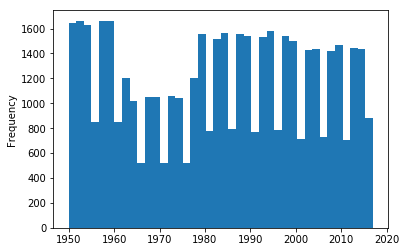

In [47]:
s = pandas.Series(pandas.DataFrame(processed)["year"])
s.plot(kind="hist",bins=40)

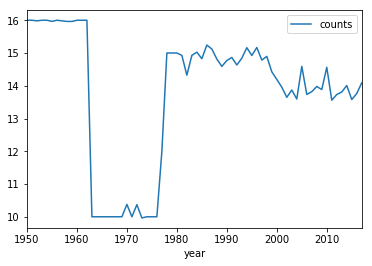

In [48]:
s = pandas.DataFrame(pandas.DataFrame(processed)[["year","date"]])
s['counts'] = s.groupby(['date']).transform('count')
s['counts'] = s['counts'].astype(int)
s_grouped = s.groupby("year")

fig_3 = s_grouped.mean().plot().get_figure()
fig_3.savefig("bestsellers_list_length.png")


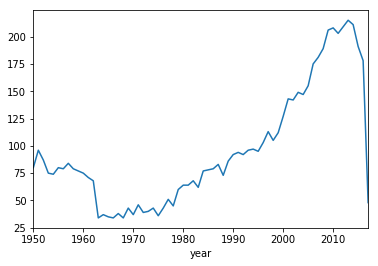

In [51]:
df = pandas.DataFrame(processed).groupby("year")
unique_counts = df.apply(unique_titles).apply(len)
fig = unique_counts.plot().get_figure()
fig.savefig("unique_titles_per_year2.png")

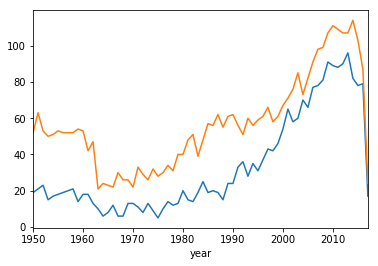

In [72]:
gendered = split_by_gender(processed)

genders = ["female","male"]

i = 0
for g in gendered:
    df = pandas.DataFrame(g).groupby("year")
    unique_counts = df.apply(unique_titles).apply(len)
    fig = unique_counts.plot().get_figure()
    fig.savefig("unique_titles_per_gender"+genders[i]+"2.png")
    i = i+1

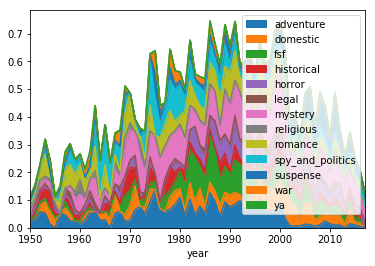

In [40]:
#tall_df = pandas.DataFrame(tally_genres_binned(processed,"year")).set_index("year")
#fig1 = tall_df.plot().get_figure()
#fig1.savefig("genre_tallies_year.png")

per_df = pandas.DataFrame(percent_genres_binned(processed,"year")).set_index("year")
fig = per_df.plot.area().get_figure()
fig.savefig("genre_percent_year3.png")

#tall_week_df = pandas.DataFrame(tally_genres_binned(processed,"date")).set_index("date")
#fig4 = tall_week_df.plot.area().get_figure()
#fig.savefig("by_week.png")

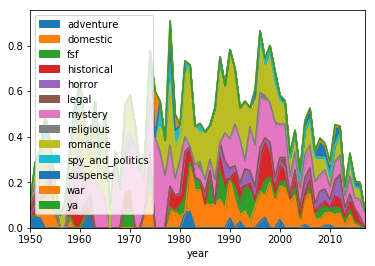

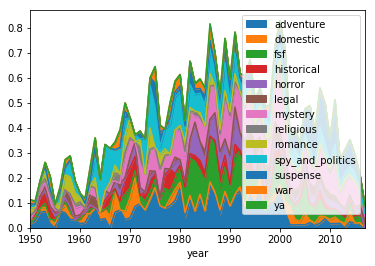

In [22]:
gendered = split_by_gender(processed)

genders = ["female","male"]

i = 0
for g in gendered:
    per_df = pandas.DataFrame(percent_genres_binned(g,"year")).set_index("year")
    fig = per_df.plot.area().get_figure()
    fig.savefig("genre_percent_year_"+genders[i]+"2.png")
    i = i+1

False
True
Female: 154
Male: 26
0.855555555556
Female: 1232
Male: 1864
0.397932816537
Female: 187
Male: 67
0.736220472441
Female: 35
Male: 1015
0.0333333333333
Female: 1931
Male: 2
0.998965338852


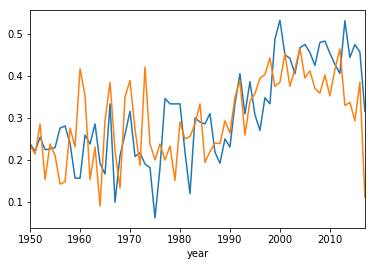

In [122]:
def is_any_genre(fast_ls):
    for x in fast_ls:
        for key in genre_dict:
#        key ="mystery"
            if is_genre(x,key):
                return True
    return False

df = pandas.DataFrame(processed)
df = df.drop_duplicates(["title","year"])
df["is_genre"] = df["fast_subjects"].apply(is_any_genre)
df["gender"] = df["genders"].apply(class_gender)

ndf = percent_women_binned(df,"year")
# df = df[df["year"].astype(int)>1990]

i = 0
grouped = df.groupby("is_genre")
for g in grouped:
    print g[0]
    p = percent_women_binned(g[1],"year")
    if i == 0:
        ax = pandas.DataFrame(p).set_index("year").plot(legend = False)
    else:
        pandas.DataFrame(p).set_index("year").plot(ax = ax,legend=False)
        fig = ax.get_figure()
        #fig.savefig("romance_v_not.png")
    i = i+1
    

grouped = df.groupby(["is_genre","gender"]).size()
grouped



i = 0
for x in grouped:
    if i%2 == 0:
        female = x
        print "Female: "+ str(female)
    else:
        male = x
        print "Male: "+ str(male)
        print float(female)/float(female+male)
    i = i+1



In [44]:
cleanup_dict = load_obj("cleanup.pickle")

for x in empties:
    ta = (x["title"],x["authors"])
    if "'" in ta[0]:
        if str(ta) not in cleanup_dict:
            proc_ta = process_input_data(ta)
            if proc_ta["owi"] != "":
                cleanup_dict[str(ta)] = proc_ta
        
print len(cleanup_dict)

adding char encoding
http://classify.oclc.org/classify2/Classify?title=HADRIAN%27S+MEMOIRS&author=Yourcenar
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=THE+STORIES+OF+FRANK+O%27CONNER&author=O'Conner
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=JARRET%27S+JADE&author=Yerby
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=THE+EXECUTIONER%27S+SONG&author=Mailler
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=RACHEL,++THE+RABBI%27S+WIFE&author=Tenenbaum
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=THE+HANDMAID%27S+TALE&author=the
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=THE+SPLENDID+OUTCAST:+Beryl+Markham%27s+African+Stories&author=Mary
False
True
adding char encoding
http://classify.oclc.org/classify2/Classify?title=THE+CHILDREN%27S+BOOK+OF+VIRTUES&author=Illustrated
Fal

[1950 1950 1950 ..., 2017 2017 2017]
Total: 114
5582
{'streak': '1', 'owi': '', 'title': 'WORLD AND ENOUGH TIME', 'year': 1950, 'rank': '6', 'fast_subjects': {}, 'year_pub': [], 'authors': ['Robert Penn Warren'], 'date': datetime.datetime(1950, 7, 9, 0, 0), 'genders': []}
{'streak': '1', 'owi': '', 'title': 'THE THIRTEEN CLOCKS', 'year': 1951, 'rank': '15', 'fast_subjects': {}, 'year_pub': [], 'authors': ['James Thurber'], 'date': datetime.datetime(1951, 1, 7, 0, 0), 'genders': []}
{'streak': '1', 'owi': '', 'title': 'THE BENGAL TIGER', 'year': 1952, 'rank': '16', 'fast_subjects': {}, 'year_pub': [], 'authors': ['Hall Hunter'], 'date': datetime.datetime(1952, 6, 22, 0, 0), 'genders': []}
{'streak': '1', 'owi': '', 'title': 'THE SINNER OF SAINT AMBROSE', 'year': 1952, 'rank': '11', 'fast_subjects': {}, 'year_pub': [], 'authors': ['Robert Reynolds'], 'date': datetime.datetime(1952, 8, 31, 0, 0), 'genders': []}
{'streak': '1', 'owi': '', 'title': "THE STORIES OF FRANK O'CONNER", 'year': 1

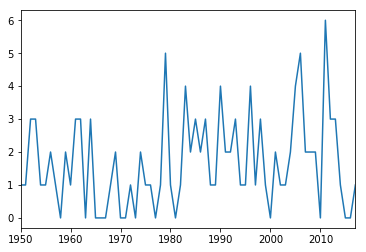

In [85]:
df = pandas.DataFrame(processed)

years = df["year"].values
print years

def init_year_dict(ls):
    df = pandas.DataFrame(ls)
    years = df["year"].values
    target = {}
    for y in years:
        target[y] = 0
    return target

def count_values(ls,column,to_count):
    target = init_year_dict(ls)
    i = 0
    if column == "genders":
        for item in ls:
            for nest_item in item[column]:
                if nest_item['gender'] == to_count:
#                    print x['authors']
                    year = item["year"]
                    target[year] = target[year]+1
                    i = i+1
    else:
        for item in ls:
            if len(item[column]) == 0:
                year = item["year"]
                target[year] = target[year]+1
                i = i+1
    print "Total: "+ str(i)
    return target

def construct_check(x_dict,field_ls):
    target = {}
    for field in field_ls:
        target[field] = x_dict[field]
    return target

def unique_entries(ls,field_ls):
    unique_fields = []
    target = []
    for x in ls:
        check_str = str(construct_check(x,field_ls))
        if check_str not in unique_fields:
            unique_fields.append(check_str)
            target.append(x)
    return target

unique_ta = []
unique_processed = unique_entries(processed,["title","authors"])
        
empties = count_values(unique_processed,"owi","")
#empties = count_values(unique_processed,"fast_subjects",[])
#empties = count_values(unique_processed,"genders","")
print len(unique_processed)
s = pandas.Series(empties)
s.plot()
s



def get_empties(ls,field):
    i = 0
    target = []
    for x in ls:
        if len(x[field]) == 0:
            target.append(x)
            if i < 10:
                print x
    return target

empties = get_empties(unique_processed,"owi")

def fill_manual_dict(orig_ls,failed_field,target):
    target = []
    empties = get_empties(orig_ls,failed_field)
    for e in empties:
        print e
    return target

In [22]:
def csv_str(ls,delim):
    target = ""
    i = 0
    for x in ls:
        target = target + str(x)
        if (i == (len(ls)-1)):
            target = target + "\n"
        else:
            target = target + str(delim)
        i = i+1
    return target

def export_to_csv_for_viz(df,filename):
    ls = csv_format_arr(df)
    with open(filename, 'w') as f:
        for row in ls:
            f.write(csv_str(row,','))
    
def csv_format_arr(df):
    target = []
    for genre in per_df:
        print(genre)
        year_ls = per_df[genre]
        print type(year_ls)
        for year in year_ls.index.values:
            row = [year,genre]
            row.append(year_ls[year])
            target.append(row)
    return target

per_df
print export_to_csv_for_viz(per_df,"potatoe1s.csv") 

adventure
<class 'pandas.core.series.Series'>
fsf
<class 'pandas.core.series.Series'>
historical
<class 'pandas.core.series.Series'>
horror
<class 'pandas.core.series.Series'>
mystery
<class 'pandas.core.series.Series'>
religious
<class 'pandas.core.series.Series'>
romance
<class 'pandas.core.series.Series'>
spy_and_politics
<class 'pandas.core.series.Series'>
suspense
<class 'pandas.core.series.Series'>
war
<class 'pandas.core.series.Series'>
ya
<class 'pandas.core.series.Series'>
None


In [105]:
titles = ['A WIDOW FOR ONE YEAR','OF LOVE AND OTHER DEMONS','DANIEL MARTIN']

def books_in_genre(data,genre):
    target = set()
    for x in data:
        for f in x["fast_subjects"]:
            if genre_candidate(f) and is_genre(f,genre):
                if (x["title"] in titles) & (str((x["title"],x["authors"])) not in target):
                    print x["title"] + ' ' + f
                target.add(str((x["title"],x["authors"])))
    return target

fsf = books_in_genre(processed,"fsf")
mystery = books_in_genre(processed,"mystery")
war = books_in_genre(processed,"war") 
domestic = books_in_genre(processed,"domestic")
romance = books_in_genre(processed,"romance")
both = domestic.intersection(romance)


#print "WAR"
#print_head(war, 20)
#print "SPIES"
#print_head(spy, 20)
print "ROMANCE"
print_head(domestic, 20)
print len(domestic)


A WIDOW FOR ONE YEAR Romance fiction
ROMANCE
('THE STORY OF EDGAR SAWTELLE', ['David Wroblewski'])
('THE CAROUSEL', ['Belva Plain'])
('THE WOMAN NEXT DOOR', ['Barbara Delinsky'])
('FAMILY TIES', ['Danielle Steel'])
('FAMILY TREE', ['Barbara Delinsky'])
('EVERY LAST ONE', ['Anna Quindlen'])
('A WOMAN OF SUBSTANCE', ['Barbara Taylor Bradford'])
('UNEXPECTED BLESSINGS', ['Barbara Taylor Bradford'])
('COAST ROAD', ['Barbara Delinsky'])
('THE WAR BETWEEN THE TATES', ['Alison Lurie'])
('RICH MAN,  POOR MAN', ['Irwin Shaw'])
('THE SHELL SEEKERS', ['Rosamunde Pilcher'])
('AND THE MOUNTAINS ECHOED', ['Khaled Hosseini'])
('GOD IS AN ENGLISHMAN', ['R.F. Delderfield'])
('SUNSET IN ST. TROPEZ', ['Danielle Steel'])
('THE HOURS', ['Michael Cunningham'])
('A PERFECT DAY', ['Richard Paul Evans'])
('A DAY LATE AND A DOLLAR SHORT', ['Terry McMillan'])
('THE ESTABLISHMENT', ['Howard Fast'])
('DADDY', ['Danielle Steel'])
('ATONEMENT', ['Ian McEwan'])
185


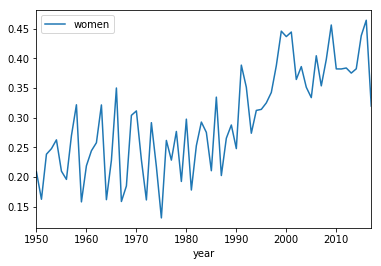

In [82]:
def split_by_gender(processed_ls):
    male = []
    female = []
    for row in processed_ls:
        gender = class_gender(row["genders"])
        if gender == "Female":
            female.append(row)
        if gender == "Male":
            male.append(row)
    return (female,male)

def percent_women_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        new_row = {}
        classified = []
        index = group[0]
        g = grouped.get_group(index)
        for authors in g["genders"]:
            classified.append(class_gender(authors))
        new_row["women"] = percent_women(classified)
        new_row[group_val] = index
        target.append(new_row)
    return target

def class_gender(gender_ls):
    
    if len(gender_ls) == 1:
        return gender_ls[0]['gender']
    else:
        fem = 0
        male = 0
        for x in gender_ls:
            if x['gender'] == 'Female': ## THIS TREATS MIXED GENDER TEAMS AS FEMALE
                fem = fem+1
                male = male+1
            else:
                if x['gender'] == 'Male':
                    male = male+1
        if fem+male == 0:
            return 'needs label'
        ratio = float(fem)/float(fem+male)
        if len(gender_ls) < 5:
            if ratio == 1:
                return 'Female'
            if ratio == 0:
                return 'Male'
            return 'Both'
        else:
            if ratio >= .8:
                return 'Female'
            if ratio <= .2:
                return 'Male'
            return 'Both'

def percent_women(class_ls):
    i = 0
    for x in class_ls:
        if x == "Female":
            i = i+1
    return float(i)/float(len(class_ls))
            
            
#for x in grouped:
#    index = x[0]
#    group = grouped.get_group(index)
#    print str(index) + str(num_titles(group))

tall_df = pandas.DataFrame(percent_women_binned(processed,"year")).set_index("year")
fig = tall_df.plot().get_figure()
#fig.savefig("women_average_week2.png")

#fig.savefig("women2")


In [50]:
def unique_titles(df_ls):
    ta = set()
    ls = df_ls["title"]
    for x in ls:
        ta.add(x)
    return ta

def num_titles(ls):
    return len(unique_titles(ls))

def count_women_unweighted(ls,group_val):
    new_df = pandas.DataFrame(ls)
    new_df["genders"] = new_df["genders"].apply(class_gender)
    grouped =  new_df.groupby([group_val,"genders"]).apply(num_titles)
    temp = {}
    for index in grouped.index.values:
        year = index[0]
        if year in temp:
            row = temp[year]
        else:
            row = {}
        gender = index[1]
        row[gender] = grouped[index]
        temp[year] = row
    target = []
    for key in temp:
        new_row = {}
        new_row["year"] = key
        menn = temp[key]["Male"]
        womenn = temp[key]["Female"]
        new_row["Male"] = float(menn)/float(menn+womenn) # SCALING
        new_row["Female"] = float(womenn)/float(menn+womenn) # SCALING
        target.append(new_row)
    return target

        Female      Male
year                    
1950  0.267606  0.732394
1951  0.250000  0.750000
1952  0.302632  0.697368
1953  0.230769  0.769231
1954  0.250000  0.750000
1955  0.253521  0.746479
1956  0.267606  0.732394
1957  0.277778  0.722222
1958  0.287671  0.712329
1959  0.205882  0.794118
1960  0.253521  0.746479
1961  0.300000  0.700000
1962  0.216667  0.783333
1963  0.322581  0.677419
1964  0.200000  0.800000
1965  0.258065  0.741935
1966  0.352941  0.647059
1967  0.166667  0.833333
1968  0.187500  0.812500
1969  0.333333  0.666667
1970  0.371429  0.628571
1971  0.250000  0.750000
1972  0.216216  0.783784
1973  0.333333  0.666667
1974  0.219512  0.780488
1975  0.151515  0.848485
1976  0.250000  0.750000
1977  0.291667  0.708333
1978  0.279070  0.720930
1979  0.245283  0.754717
...        ...       ...
1988  0.214286  0.785714
1989  0.282353  0.717647
1990  0.279070  0.720930
1991  0.370787  0.629213
1992  0.413793  0.586207
1993  0.318182  0.681818
1994  0.384615  0.615385


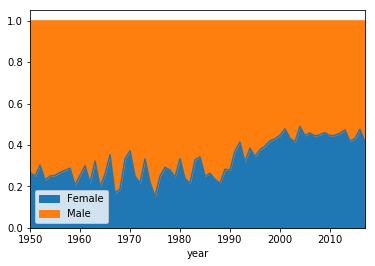

In [66]:
df = pandas.DataFrame(count_women_unweighted(processed,"year"))
#df = df[df["year"]>2000]
df = df.set_index("year")

ax = df.plot.area()
print df
womens_fig = ax.get_figure()
womens_fig.savefig("womens_fig_scaled2.png")

{'streak': '17', 'owi': '2908457233', 'title': 'THE EGYPTIAN', 'authors': ['Mika Waltari'], 'rank': '1', 'fast_subjects': {'Egypt': 1930, 'Akhenaton, King of Egypt': 52, 'Epic literature': 65, 'Historical fiction': 117}, 'year_pub': '1949', 'year': 1950, 'date': datetime.datetime(1950, 1, 1, 0, 0), 'genders': [{'gender': '', 'viaf': '111008219', 'name': 'Mika Waltari'}], 'month': 1}
{'streak': '12', 'owi': '561899', 'title': 'THE PLAINS OF PASSAGE', 'authors': ['Jean M. Auel'], 'rank': '1', 'fast_subjects': {'Europe': 6411, 'Ayla (Fictitious character)': 6801, 'Prehistoric peoples': 6961, 'Historical fiction': 29, 'Primitive societies': 857, 'Glacial epoch': 6632, 'Women': 30}, 'year_pub': '1985', 'year': 1991, 'date': datetime.datetime(1991, 1, 6, 0, 0), 'genders': [{'gender': 'Female', 'viaf': '79487364', 'name': 'Jean M. Auel'}], 'month': 1}
{'streak': '8', 'owi': '2986997958', 'title': 'THE WHISTLER', 'authors': ['John Grisham'], 'rank': '1', 'fast_subjects': {'Trials (Murder)': 23

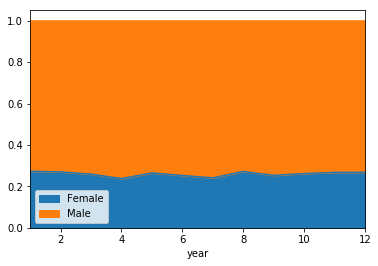

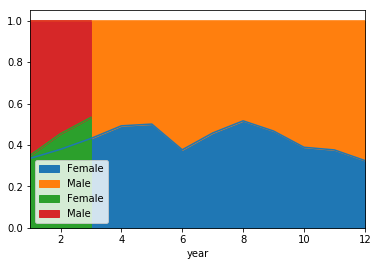

In [59]:


def make_month_col(ls,comp_str,subset_val):
    new_ls = []
    for x in processed:
        year = int(x["year"])
        if comp_str == "<":
            comp = (year < subset_val)
        if comp_str == ">":
            comp = (year > subset_val)
        if comp_str == "=":
            comp = (year == subset_val)
        if comp:
            y = dict(x)
            y["month"] = x["date"].month
            new_ls.append(y)
    return new_ls

new_p = make_month_col(processed,"<",1990)
print new_p[0]
df = pandas.DataFrame(count_women_unweighted(new_p,"month")).set_index("year")
fig = df.plot.area().get_figure()
fig.savefig("month_avg_before1990.png")

#####

new_p = make_month_col(processed,">",1990)
print new_p[0]
df = pandas.DataFrame(count_women_unweighted(new_p,"month")).set_index("year")
fig2 = df.plot.area()#.get_figure()
#fig2.savefig("month_avg_after1990.png")

new_p = make_month_col(processed,"=",2017)
    
print new_p[0]
df = pandas.DataFrame(count_women_unweighted(new_p,"month")).set_index("year")
df.plot.area(ax = fig2)
fig3 = fig2.get_figure()
fig3.savefig("month_2017_comp.png")

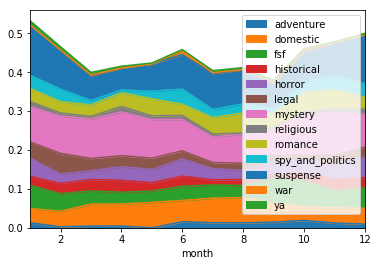

In [60]:
with_month = make_month_col(processed,">",2000) ## all of them

per_df = pandas.DataFrame(percent_genres_binned(with_month,"month")).set_index("month")
fig = per_df.plot.area().get_figure()

In [64]:

def new_class_genre(subject_ls):
    target = []
    for sub in subject_ls:
        if genre_candidate(sub):
            for genre in genre_dict:
                if is_genre(sub,genre):
                    target.append(genre)
    if len(target) > 1:
        return random.choice(target)
    if len(subject_ls)>0:
        return "zz_no genre"
    else:
        return "needs label"

df = pandas.DataFrame(processed)
df = df.drop_duplicates(["title","year"])
df["genre"] = df["fast_subjects"].apply(new_new_class_genre)
df["gender"] = df["genders"].apply(class_gender)
df.to_csv("the_processed_data.csv",sep='\t')

In [55]:
def select_genre(genre_hold):
    max_holds = []
    max_hold_count = 0
    for genre in genre_hold:
        current_hold_count = genre_hold[genre]
        if current_hold_count > max_hold_count:
            max_holds = [genre]
            max_hold_count = current_hold_count
        else:
            if current_hold_count == max_hold_count:
                max_holds.append(genre)
    if len(max_holds)==1:
        return max_holds[0]
    if len(max_holds)>1:
        return random.choice(max_holds)


def new_new_class_genre(subject_ls):
    primary_genres = {}
    for sub in subject_ls:
        hold = subject_ls[sub]
        if genre_candidate(sub):
            for genre in genre_dict:
                if is_genre(sub,genre):
                    if genre in primary_genres:
                        primary_genres[genre] = primary_genres[genre] + hold
                    else:
                        primary_genres[genre] = hold
    if len(primary_genres)>0:
        return select_genre(primary_genres)
    if len(subject_ls)>0:
        return "zz_no genre"
    else:
        return "needs label"

    
test_g = {'Married women': 1478, 'Romance fiction': 1482, 'Crime fiction (Social class)': 557, 
          'Detective fiction': 1482, 'English fiction': 1715, 'English fiction': 76, 
          'England': 1551, 'Runaway wives': 557}

new_new_class_genre(test_g)

'mystery'

443


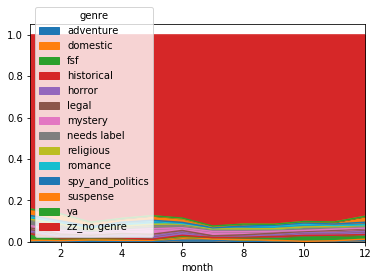

In [61]:
with_month = make_month_col(processed,">",2000) ## all of them
month_df = pandas.DataFrame(with_month)
month_df = month_df.drop_duplicates(["title","month"])
month_df["genre"] = month_df["fast_subjects"].apply(new_class_genre)
month_df["gender"] = month_df["genders"].apply(class_gender)

mg_df = pandas.DataFrame({'count' : month_df.groupby( ["month", "genre"] ).size()}).reset_index()
#print mg_df

df3 = pandas.DataFrame({'sum' : month_df.groupby("month").size()})
#print df3
print df3.loc[3]["sum"]

def count_to_percent(value,group):
    s = df3.loc[group]["sum"]
    return float(value)/float(s)

### USEFUL LINE -- CONVERTS TO PERCENT!
mg_df["percent"] = mg_df.apply(lambda x: count_to_percent(x['count'], x['month']), axis=1)
mg_df = mg_df.pivot(index='month', columns='genre', values='percent')

#df_year_genre = df_year_genre.pivot(index='year', columns='genre', values='count')
figure = mg_df.plot(kind = 'area')


215


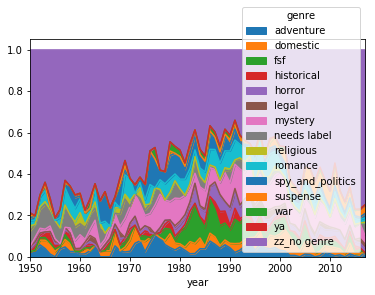

In [65]:
yg_df = pandas.DataFrame({'count' : df.groupby( ["year", "genre"] ).size()}).reset_index()

df3 = pandas.DataFrame({'sum' : df.groupby("year").size()}).reset_index()
df3 = df3.set_index("year")
print df3.loc[2013]["sum"]

### USEFUL LINE -- CONVERTS TO PERCENT!
yg_df["percent"] = yg_df.apply(lambda x: count_to_percent(x['count'], x['year']), axis=1)

### TOGGLE THESE
### PERCENT:

yg_df = yg_df.pivot(index='year', columns='genre', values='percent')

### COUNTS:

#yg_df = yg_df.pivot(index='year', columns='genre', values='count')

figure = yg_df.plot(kind = 'area')
#g = df.groupby(["year"])
#df_grouped = pandas.DataFrame({'count': g["genre"].value_counts()})#.plot()
#df_grouped

In [238]:
print df_to_json(df2)

<type 'dict'>
[{'values': [[1041408000, 11.0], [852105600, 14.0], [568022400, 4.0], [599644800, 12.0], [504950400, 8.0], [536486400, 9.0], [441792000, 6.0], [473414400, 7.0], [-63129600, 1.0], [-31507200, 4.0], [315561600, 8.0], [347184000, 5.0], [-189360000, 1.0], [-157737600, None], [-126201600, 1.0], [-94665600, 2.0], [-315590400, 5.0], [-283968000, 1.0], [-252432000, 3.0], [-220896000, 3.0], [820483200, 14.0], [1388563200, 16.0], [1483257600, 3.0], [1451635200, 12.0], [1293868800, 23.0], [1262332800, 14.0], [1357027200, 17.0], [1325404800, 12.0], [1420099200, 13.0], [1104566400, 8.0], [-473356800, 1.0], [-504892800, 2.0], [-410198400, None], [-441820800, None], [-599587200, 2.0], [-631123200, None], [-536428800, 1.0], [-568051200, 2.0], [378720000, 6.0], [-347126400, 2.0], [-378662400, 1.0], [410256000, 3.0], [662716800, 12.0], [631180800, 12.0], [725875200, 10.0], [694252800, 15.0], [788947200, 8.0], [757411200, 15.0], [284025600, 6.0], [252489600, 5.0], [220953600, 6.0], [1893312

In [237]:
import time

def time_from_y(y):
    dt = datetime(year=int(y), month=1, day=1)
    tt = time.mktime(dt.timetuple())
    return int(tt)

def df_to_json(dataframe):
    j = dataframe.to_json()
    j = json.loads(j)
    print type(j)
    k = []
    for x in j:
        target = {}
        target["key"] = x
        v = []
        for y in j[x]:
            timey = time_from_y(y)
            value = j[x][y]
            point = [timey,value]
            v.append(point)
        target["values"] = v
        k.append(target)
    return k

In [136]:
per_df

,adventure,domestic,fsf,historical,horror,legal,mystery,religious,romance,spy_and_politics,suspense,war,ya
month,,,,,,,,,,,,,
1,0.013441,0.048387,0.053763,0.018817,0.045699,0.037634,0.075269,0.013441,0.032258,0.026882,0.123656,0.000000,0.010753
2,0.000000,0.046961,0.049724,0.027624,0.019337,0.038674,0.080110,0.008287,0.022099,0.022099,0.091160,0.002762,0.008287
3,0.004662,0.051282,0.032634,0.030303,0.020979,0.032634,0.081585,0.006993,0.030303,0.009324,0.053613,0.002331,0.006993
4,0.004843,0.055690,0.021792,0.029056,0.036320,0.026634,0.084746,0.007264,0.038741,0.007264,0.041162,0.000000,0.004843
5,0.002506,0.062657,0.030075,0.017544,0.032581,0.025063,0.087719,0.007519,0.037594,0.022556,0.062657,0.000000,0.002506
6,0.018868,0.053908,0.029650,0.021563,0.037736,0.021563,0.072776,0.008086,0.029650,0.037736,0.072776,0.010782,0.002695
7,0.013514,0.067568,0.027027,0.008108,0.021622,0.016216,0.070270,0.005405,0.043243,0.021622,0.083784,0.002703,0.008108
8,0.008000,0.066667,0.029333,0.013333,0.021333,0.018667,0.074667,0.000000,0.053333,0.024000,0.082667,0.000000,0.005333
9,0.015113,0.050378,0.047859,0.007557,0.027708,0.017632,0.060453,0.000000,0.037783,0.005038,0.047859,0.002519,0.005038
